# Method 3 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

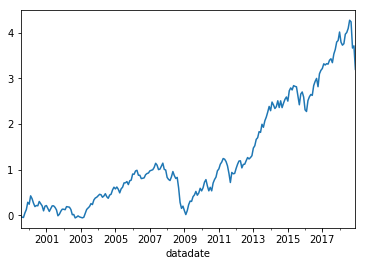

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.286676
2000-12-31   -0.065782
2001-12-31   -0.054961
2002-12-31   -0.148446
2003-12-31    0.444588
2004-12-31    0.157025
2005-12-31    0.095948
2006-12-31    0.087578
2007-12-31    0.034036
2008-12-31   -0.396625
2009-12-31    0.324738
2010-12-31    0.240445
2011-12-31   -0.029227
2012-12-31    0.201956
2013-12-31    0.467624
2014-12-31    0.061064
2015-12-31   -0.000100
2016-12-31    0.162357
2017-12-31    0.156648
2018-12-31   -0.130851
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     734.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.73e-129
Time:                        13:03:30   Log-Likelihood:                 676.78
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.021      0.309      -0.001       0.003
mktrf          1.0027      0.025     39.635      0.000       0.953       1.053
me             0.4949      0.029     16.819      0.000       0.437       0.553
ia             0.0037      0.045      0.083      0.934      -0.084       0.092
roe            0.1408      0.038      3.679      0.000       0.065       0.216
==============================================================================
Omnibus:                       43.202   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.960
Skew:                          -0.009   Prob(JB):                    9.02e-108
Kurtosis:                      10.111   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     705.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.92e-127
Time:                        13:03:30   Log-Likelihood:                 676.78
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.136      0.256      -0.001       0.003
mktrf          1.0027      0.027     37.168      0.000       0.950       1.056
me             0.4949      0.030     16.328      0.000       0.436       0.554
ia             0.0037      0.091      0.040      0.968      -0.176       0.183
roe            0.1408      0.046      3.057      0.002       0.051       0.231
==============================================================================
Omnibus:                       43.202   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.960
Skew:                          -0.009   Prob(JB):                    9.02e-108
Kurtosis:                      10.111   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     915.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.48e-139
Time:                        13:03:30   Log-Likelihood:                 676.78
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.303      0.193      -0.000       0.002
mktrf          1.0027      0.023     42.719      0.000       0.957       1.049
me             0.4949      0.027     18.095      0.000       0.441       0.549
ia             0.0037      0.091      0.041      0.968      -0.175       0.182
roe            0.1408      0.044      3.209      0.001       0.055       0.227
==============================================================================
Omnibus:                       43.202   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.960
Skew:                          -0.009   Prob(JB):                    9.02e-108
Kurtosis:                      10.111   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     472.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.65e-118
Time:                        13:03:30   Log-Likelihood:                 653.91
No. Observations:                 234   AIC:                            -1296.
Df Residuals:                     228   BIC:                            -1275.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.300      0.195      -0.001       0.003
mktrf          0.9804      0.028     34.999      0.000       0.925       1.036
smb            0.4978      0.037     13.467      0.000       0.425       0.571
hml           -0.0051      0.044     -0.117      0.907      -0.091       0.081
rmw            0.0604      0.049      1.225      0.222      -0.037       0.157
cma            0.0539      0.063      0.861      0.390      -0.069       0.177
==============================================================================
Omnibus:                       44.684   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.899
Skew:                           0.172   Prob(JB):                    3.80e-110
Kurtosis:                      10.181   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     719.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.06e-137
Time:                        13:03:30   Log-Likelihood:                 653.91
No. Observations:                 234   AIC:                            -1296.
Df Residuals:                     228   BIC:                            -1275.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.176      0.240      -0.001       0.004
mktrf          0.9804      0.037     26.821      0.000       0.909       1.052
smb            0.4978      0.049     10.195      0.000       0.402       0.593
hml           -0.0051      0.076     -0.067      0.947      -0.155       0.144
rmw            0.0604      0.086      0.701      0.483      -0.108       0.229
cma            0.0539      0.127      0.424      0.672      -0.195       0.303
==============================================================================
Omnibus:                       44.684   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.899
Skew:                           0.172   Prob(JB):                    3.80e-110
Kurtosis:                      10.181   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     751.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.03e-139
Time:                        13:03:30   Log-Likelihood:                 653.91
No. Observations:                 234   AIC:                            -1296.
Df Residuals:                     228   BIC:                            -1275.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.219      0.223      -0.001       0.004
mktrf          0.9804      0.033     29.306      0.000       0.915       1.046
smb            0.4978      0.049     10.149      0.000       0.402       0.594
hml           -0.0051      0.078     -0.065      0.948      -0.159       0.148
rmw            0.0604      0.092      0.659      0.510      -0.119       0.240
cma            0.0539      0.134      0.402      0.688      -0.209       0.317
==============================================================================
Omnibus:                       44.684   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.899
Skew:                           0.172   Prob(JB):                    3.80e-110
Kurtosis:                      10.181   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     675.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.78e-125
Time:                        13:03:30   Log-Likelihood:                 667.80
No. Observations:                 234   AIC:                            -1326.
Df Residuals:                     229   BIC:                            -1308.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.118      0.265      -0.001       0.003
mktrf          1.0293      0.024     42.529      0.000       0.982       1.077
smb            0.4010      0.030     13.273      0.000       0.341       0.461
hml            0.1598      0.030      5.323      0.000       0.101       0.219
umd            0.1338      0.020      6.795      0.000       0.095       0.173
==============================================================================
Omnibus:                       75.934   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1154.368
Skew:                          -0.782   Prob(JB):                    2.15e-251
Kurtosis:                      13.768   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     612.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.74e-121
Time:                        13:03:30   Log-Likelihood:                 667.80
No. Observations:                 234   AIC:                            -1326.
Df Residuals:                     229   BIC:                            -1308.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.305      0.192      -0.001       0.003
mktrf          1.0293      0.035     29.402      0.000       0.961       1.098
smb            0.4010      0.039     10.367      0.000       0.325       0.477
hml            0.1598      0.064      2.509      0.012       0.035       0.285
umd            0.1338      0.040      3.376      0.001       0.056       0.211
==============================================================================
Omnibus:                       75.934   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1154.368
Skew:                          -0.782   Prob(JB):                    2.15e-251
Kurtosis:                      13.768   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     812.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.78e-134
Time:                        13:03:30   Log-Likelihood:                 667.80
No. Observations:                 234   AIC:                            -1326.
Df Residuals:                     229   BIC:                            -1308.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.481      0.139      -0.000       0.002
mktrf          1.0293      0.029     35.218      0.000       0.972       1.087
smb            0.4010      0.038     10.630      0.000       0.327       0.475
hml            0.1598      0.065      2.457      0.014       0.032       0.287
umd            0.1338      0.033      4.090      0.000       0.070       0.198
==============================================================================
Omnibus:                       75.934   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1154.368
Skew:                          -0.782   Prob(JB):                    2.15e-251
Kurtosis:                      13.768   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     290.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.08e-59
Time:                        13:03:30   Log-Likelihood:                 322.93
No. Observations:                 120   AIC:                            -635.9
Df Residuals:                     115   BIC:                            -621.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.631      0.529      -0.002       0.004
mktrf          1.0303      0.043     23.850      0.000       0.945       1.116
me             0.5045      0.043     11.823      0.000       0.420       0.589
ia            -0.0187      0.067     -0.280      0.780      -0.151       0.114
roe            0.2219      0.059      3.753      0.000       0.105       0.339
==============================================================================
Omnibus:                       21.281   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.881
Skew:                          -0.091   Prob(JB):                     2.81e-28
Kurtosis:                       8.034   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     303.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.31e-60
Time:                        13:03:30   Log-Likelihood:                 322.93
No. Observations:                 120   AIC:                            -635.9
Df Residuals:                     115   BIC:                            -621.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.724      0.469      -0.002       0.004
mktrf          1.0303      0.045     23.120      0.000       0.943       1.118
me             0.5045      0.040     12.676      0.000       0.426       0.582
ia            -0.0187      0.116     -0.162      0.872      -0.246       0.208
roe            0.2219      0.052      4.239      0.000       0.119       0.325
==============================================================================
Omnibus:                       21.281   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.881
Skew:                          -0.091   Prob(JB):                     2.81e-28
Kurtosis:                       8.034   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     420.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-67
Time:                        13:03:30   Log-Likelihood:                 322.93
No. Observations:                 120   AIC:                            -635.9
Df Residuals:                     115   BIC:                            -621.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.859      0.391      -0.001       0.003
mktrf          1.0303      0.033     30.934      0.000       0.965       1.096
me             0.5045      0.036     13.901      0.000       0.433       0.576
ia            -0.0187      0.114     -0.164      0.870      -0.243       0.206
roe            0.2219      0.037      6.039      0.000       0.150       0.294
==============================================================================
Omnibus:                       21.281   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.881
Skew:                          -0.091   Prob(JB):                     2.81e-28
Kurtosis:                       8.034   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     165.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.72e-50
Time:                        13:03:30   Log-Likelihood:                 305.02
No. Observations:                 120   AIC:                            -598.0
Df Residuals:                     114   BIC:                            -581.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.178      0.241      -0.002       0.006
mktrf          0.9848      0.053     18.540      0.000       0.880       1.090
smb            0.5028      0.060      8.359      0.000       0.384       0.622
hml           -0.0253      0.074     -0.343      0.733      -0.171       0.121
rmw            0.0924      0.087      1.063      0.290      -0.080       0.265
cma            0.0808      0.095      0.848      0.398      -0.108       0.269
==============================================================================
Omnibus:                       18.032   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.578
Skew:                           0.099   Prob(JB):                     7.10e-19
Kurtosis:                       7.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     441.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.72e-73
Time:                        13:03:30   Log-Likelihood:                 305.02
No. Observations:                 120   AIC:                            -598.0
Df Residuals:                     114   BIC:                            -581.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.055      0.291      -0.002       0.006
mktrf          0.9848      0.074     13.289      0.000       0.840       1.130
smb            0.5028      0.075      6.710      0.000       0.356       0.650
hml           -0.0253      0.124     -0.204      0.839      -0.268       0.218
rmw            0.0924      0.146      0.631      0.528      -0.195       0.380
cma            0.0808      0.164      0.493      0.622      -0.240       0.402
==============================================================================
Omnibus:                       18.032   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.578
Skew:                           0.099   Prob(JB):                     7.10e-19
Kurtosis:                       7.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     485.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.29e-75
Time:                        13:03:30   Log-Likelihood:                 305.02
No. Observations:                 120   AIC:                            -598.0
Df Residuals:                     114   BIC:                            -581.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.090      0.276      -0.002       0.006
mktrf          0.9848      0.070     14.085      0.000       0.848       1.122
smb            0.5028      0.077      6.538      0.000       0.352       0.654
hml           -0.0253      0.129     -0.195      0.845      -0.279       0.228
rmw            0.0924      0.161      0.575      0.565      -0.223       0.408
cma            0.0808      0.170      0.476      0.634      -0.252       0.413
==============================================================================
Omnibus:                       18.032   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.578
Skew:                           0.099   Prob(JB):                     7.10e-19
Kurtosis:                       7.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     256.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.69e-56
Time:                        13:03:30   Log-Likelihood:                 316.15
No. Observations:                 120   AIC:                            -622.3
Df Residuals:                     115   BIC:                            -608.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.578      0.117      -0.001       0.006
mktrf          1.0539      0.040     26.169      0.000       0.974       1.134
smb            0.3670      0.046      8.005      0.000       0.276       0.458
hml            0.1720      0.046      3.744      0.000       0.081       0.263
umd            0.1599      0.028      5.648      0.000       0.104       0.216
==============================================================================
Omnibus:                       46.058   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.910
Skew:                          -1.039   Prob(JB):                     3.41e-70
Kurtosis:                      10.724   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     317.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.74e-61
Time:                        13:03:30   Log-Likelihood:                 316.15
No. Observations:                 120   AIC:                            -622.3
Df Residuals:                     115   BIC:                            -608.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.787      0.074      -0.000       0.005
mktrf          1.0539      0.055     19.282      0.000       0.947       1.161
smb            0.3670      0.049      7.433      0.000       0.270       0.464
hml            0.1720      0.075      2.282      0.022       0.024       0.320
umd            0.1599      0.050      3.190      0.001       0.062       0.258
==============================================================================
Omnibus:                       46.058   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.910
Skew:                          -1.039   Prob(JB):                     3.41e-70
Kurtosis:                      10.724   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     559.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.35e-74
Time:                        13:03:30   Log-Likelihood:                 316.15
No. Observations:                 120   AIC:                            -622.3
Df Residuals:                     115   BIC:                            -608.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.064      0.039       0.000       0.005
mktrf          1.0539      0.039     26.922      0.000       0.977       1.131
smb            0.3670      0.044      8.429      0.000       0.282       0.452
hml            0.1720      0.073      2.362      0.018       0.029       0.315
umd            0.1599      0.036      4.395      0.000       0.089       0.231
==============================================================================
Omnibus:                       46.058   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.910
Skew:                          -1.039   Prob(JB):                     3.41e-70
Kurtosis:                      10.724   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     794.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-79
Time:                        13:03:30   Log-Likelihood:                 388.57
No. Observations:                 114   AIC:                            -767.1
Df Residuals:                     109   BIC:                            -753.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.385      0.169      -0.000       0.003
mktrf          0.9899      0.024     41.116      0.000       0.942       1.038
me             0.4601      0.037     12.377      0.000       0.386       0.534
ia            -0.0365      0.052     -0.708      0.480      -0.139       0.066
roe           -0.0944      0.045     -2.084      0.039      -0.184      -0.005
==============================================================================
Omnibus:                        0.469   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.527
Skew:                          -0.148   Prob(JB):                        0.768
Kurtosis:                       2.849   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1725.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-97
Time:                        13:03:30   Log-Likelihood:                 388.57
No. Observations:                 114   AIC:                            -767.1
Df Residuals:                     109   BIC:                            -753.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.231      0.218      -0.001       0.003
mktrf          0.9899      0.023     42.625      0.000       0.944       1.035
me             0.4601      0.035     13.058      0.000       0.391       0.529
ia            -0.0365      0.051     -0.712      0.477      -0.137       0.064
roe           -0.0944      0.045     -2.116      0.034      -0.182      -0.007
==============================================================================
Omnibus:                        0.469   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.527
Skew:                          -0.148   Prob(JB):                        0.768
Kurtosis:                       2.849   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     2437.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-105
Time:                        13:03:30   Log-Likelihood:                 388.57
No. Observations:                 114   AIC:                            -767.1
Df Residuals:                     109   BIC:                            -753.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.237      0.216      -0.001       0.003
mktrf          0.9899      0.025     39.533      0.000       0.941       1.039
me             0.4601      0.035     13.104      0.000       0.391       0.529
ia            -0.0365      0.054     -0.681      0.496      -0.142       0.069
roe           -0.0944      0.041     -2.317      0.021      -0.174      -0.015
==============================================================================
Omnibus:                        0.469   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.527
Skew:                          -0.148   Prob(JB):                        0.768
Kurtosis:                       2.849   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     780.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.93e-83
Time:                        13:03:30   Log-Likelihood:                 400.49
No. Observations:                 114   AIC:                            -789.0
Df Residuals:                     108   BIC:                            -772.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.212      0.833      -0.001       0.002
mktrf          1.0043      0.021     48.338      0.000       0.963       1.045
smb            0.4497      0.034     13.332      0.000       0.383       0.517
hml           -0.0341      0.043     -0.793      0.429      -0.119       0.051
rmw           -0.1411      0.053     -2.679      0.009      -0.246      -0.037
cma           -0.0258      0.067     -0.385      0.701      -0.158       0.107
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.431
Skew:                           0.052   Prob(JB):                        0.489
Kurtosis:                       2.461   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1542.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.16e-98
Time:                        13:03:30   Log-Likelihood:                 400.49
No. Observations:                 114   AIC:                            -789.0
Df Residuals:                     108   BIC:                            -772.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.177      0.860      -0.002       0.002
mktrf          1.0043      0.021     48.455      0.000       0.964       1.045
smb            0.4497      0.035     13.033      0.000       0.382       0.517
hml           -0.0341      0.037     -0.925      0.355      -0.106       0.038
rmw           -0.1411      0.041     -3.415      0.001      -0.222      -0.060
cma           -0.0258      0.061     -0.423      0.672      -0.145       0.094
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.431
Skew:                           0.052   Prob(JB):                        0.489
Kurtosis:                       2.461   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3060.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.42e-114
Time:                        13:03:30   Log-Likelihood:                 400.49
No. Observations:                 114   AIC:                            -789.0
Df Residuals:                     108   BIC:                            -772.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.179      0.858      -0.002       0.002
mktrf          1.0043      0.021     46.936      0.000       0.962       1.046
smb            0.4497      0.033     13.511      0.000       0.384       0.515
hml           -0.0341      0.034     -0.998      0.318      -0.101       0.033
rmw           -0.1411      0.043     -3.315      0.001      -0.225      -0.058
cma           -0.0258      0.053     -0.487      0.626      -0.130       0.078
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.431
Skew:                           0.052   Prob(JB):                        0.489
Kurtosis:                       2.461   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     882.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.13e-82
Time:                        13:03:30   Log-Likelihood:                 394.36
No. Observations:                 114   AIC:                            -778.7
Df Residuals:                     109   BIC:                            -765.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.370      0.712      -0.002       0.001
mktrf          1.0211      0.022     47.090      0.000       0.978       1.064
smb            0.4758      0.034     14.073      0.000       0.409       0.543
hml            0.0280      0.035      0.804      0.423      -0.041       0.097
umd            0.0176      0.026      0.669      0.505      -0.035       0.070
==============================================================================
Omnibus:                        1.195   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                1.126
Skew:                          -0.091   Prob(JB):                        0.570
Kurtosis:                       2.549   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     912.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.70e-83
Time:                        13:03:30   Log-Likelihood:                 394.36
No. Observations:                 114   AIC:                            -778.7
Df Residuals:                     109   BIC:                            -765.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.320      0.749      -0.002       0.001
mktrf          1.0211      0.023     43.675      0.000       0.975       1.067
smb            0.4758      0.031     15.214      0.000       0.415       0.537
hml            0.0280      0.026      1.090      0.276      -0.022       0.078
umd            0.0176      0.018      0.974      0.330      -0.018       0.053
==============================================================================
Omnibus:                        1.195   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                1.126
Skew:                          -0.091   Prob(JB):                        0.570
Kurtosis:                       2.549   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1898.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.20e-100
Time:                        13:03:30   Log-Likelihood:                 394.36
No. Observations:                 114   AIC:                            -778.7
Df Residuals:                     109   BIC:                            -765.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.348      0.728      -0.002       0.001
mktrf          1.0211      0.024     42.205      0.000       0.974       1.068
smb            0.4758      0.027     17.461      0.000       0.422       0.529
hml            0.0280      0.026      1.080      0.280      -0.023       0.079
umd            0.0176      0.016      1.074      0.283      -0.014       0.050
==============================================================================
Omnibus:                        1.195   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                1.126
Skew:                          -0.091   Prob(JB):                        0.570
Kurtosis:                       2.549   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""